In [2]:
import matplotlib.pyplot as plt
import numpy as np 
from specutils.manipulation import FluxConservingResampler
import pandas as pd
from uncertainties import unumpy as unp, ufloat
from scipy import constants
from pathlib import Path
from typing import Tuple, List
from functools import partial
from time import time
import concurrent.futures
from tqdm import tqdm

In [97]:
import numpy as np
amplitudes = []
for i in range(10):
    # Wavelengths (microns)
    wavelength = np.linspace(2.5, 7.5, 1000)

    # Baseline transit depth
    baseline = 0.010

    # Absorption feature at 5 microns
    feature_center = 5.0
    feature_width = 0.25
    feature_amplitude = np.random.uniform(2e-4, 1e-3)
    amplitudes.append(feature_amplitude)

    feature = feature_amplitude * np.exp(
        -0.5 * ((wavelength - feature_center) / feature_width)**2
    )

    # Measurement noise
    noise = np.random.normal(0, 4e-5, size=wavelength.size)

    # Transit depth
    transit_depth = baseline + feature + noise

    # JWST-like uncertainties (slightly wavelength-dependent)
    yerr = 3e-5 + 2e-5 * (wavelength - wavelength.min()) / (wavelength.max() - wavelength.min())
    dumby= np.zeros_like(wavelength)

    # Final array: [x, y, y_err]
    spectrum = np.column_stack((wavelength, dumby, transit_depth, yerr))
    np.savetxt(f'Data/Fake_Data_for_folder_testing/sim_obs{i}.txt', spectrum)

In [72]:
print(amplitudes)

[0.0009257602195585026, 0.0002099019914193991, 0.0003024960092218319, 0.0003936950857258146, 0.0003687044484210883, 0.0003288066585064593, 0.0006153959804672307, 0.0008604344096790501, 0.00029251768890765, 0.0007776413094012449]


In [100]:


df = pd.read_csv('Data/composite_exo_data-unfiltered.csv', comment='#')


class PeakFinder:
    def __init__(self):
        self.Feture_threshold = 0.15  # wavelength range around feature centers (microns)
        self.feture_top = 5.0  # feature peak location
        self.feture_bottom = 4.5  # baseline location away from feature
        self.MAX_WORKERS = 8
        self.bin_size = 10  # Binning size in microns

    def Binning(self, data):
        """This function bins the data to reduce noise.
        Input is the data array
        Output is the binned data array"""
        Wavelengths= data[:,0] # in microns
        Spectrum= data[:,2] # data with the noise (Rp/Rs)^2
        error_bars= data[:,3] # error bars 
        Binned_Wavelengths = []
        Binned_Spectrum = []
        Binned_error_bars = []
        for i in range(0, len(Wavelengths), self.bin_size):
            Binned_Wavelengths.append(np.mean(Wavelengths[i:i+self.bin_size]))
            Binned_Spectrum.append(np.mean(Spectrum[i:i+self.bin_size]))
            Binned_error_bars.append(np.sqrt(np.sum(error_bars[i:i+self.bin_size]**2)) / self.bin_size)
        bumby = np.zeros_like(Binned_Wavelengths)
        binned_data = np.column_stack((Binned_Wavelengths, bumby, Binned_Spectrum, Binned_error_bars))
        return binned_data
    

    
    def find_peaks(self, data):
        """This Function takes a spectrun array and looks for a feture depth between two ranges.
        Input is just the data array
        Output is the feture depth and its error bar"""
        mask = data[:, 3] <= 0.001 # take out the bit where the error bars go crazy 
        Proper_datset = data[mask] #data after applying the mask

        Wavelengths= Proper_datset[:,0] # in microns
        Spectrum= Proper_datset[:,2] # data with the noise (Rp/Rs)^2
        error_bars= Proper_datset[:,3] # error bars 

        Top_range_mask= (Wavelengths >= self.feture_top  - self.Feture_threshold) & (Wavelengths <= self.feture_top  + self.Feture_threshold)
        Bottom_range_mask= (Wavelengths >= self.feture_bottom - self.Feture_threshold) & (Wavelengths <= self.feture_bottom + self.Feture_threshold)
        Top_range= Spectrum[Top_range_mask]
        Bottom_range= Spectrum[Bottom_range_mask]
        Average_top= np.mean(Top_range)
        Average_bottom= np.mean(Bottom_range)
        Feature_depth= Average_top - Average_bottom
        Top_range_error = error_bars[Top_range_mask]
        Bottom_range_error = error_bars[Bottom_range_mask]
        # Proper error propagation for difference of means
        # When combining N measurements with errors σᵢ, the error in the mean is sqrt(sum(σᵢ²))/N
        Top_error = np.sqrt(np.sum(Top_range_error**2)) / len(Top_range_error)
        Bottom_error = np.sqrt(np.sum(Bottom_range_error**2)) / len(Bottom_range_error)
        # Error in the difference: sqrt(σ_top² + σ_bottom²)
        Feature_depth_error = np.sqrt(Top_error**2 + Bottom_error**2)

        print(f"The feture depth is {Feature_depth} +/- {Feature_depth_error} (Rp/Rs)^2")
        return Feature_depth, Feature_depth_error
    

    def Find_A_H(self, peak_height, Error, planet_name):
        R_R = df.loc[df['pl_name'] == planet_name, 'pl_ratror'].values[0][0]  # radius ratio (R_p / R_s)
        R_p = df.loc[df['pl_name'] == planet_name, 'pl_rade'].values[0][0]   # planetary radius in earth radii
        R_s=R_p/R_R # stellar radius in earth radii
        R_p_error = "unknown" # planetary radius error in earth radii
        R_s_error = "unknown" # stellar radius error in earth radii
        g = "unknown"  # surface gravity in m/s^2 need to get from somewhere
        g_error = "unknown"  # surface gravity error in m/s^2
        T_eq = "unknown"   # equilibrium temperature in K need to get from somewhere
        T_eq_error = "unknown"  # equilibrium temperature error in K
        mu = 2.3 # mean molecular weight (assuming H2 dominated atmosphere)
        k_B = constants.physical_constants['Boltzmann constant'][0]  # Boltzmann constant in J/K

        R_p_full = ufloat(R_p, R_p_error)  # Assuming negligible error for radius ratio
        R_s_full = ufloat(R_s, R_s_error)  # Assuming negligible error for radius ratio
        g_full = ufloat(g, g_error)
        T_eq_full = ufloat(T_eq, T_eq_error)
        Peak_height_full = ufloat(peak_height, Error)
        

        # Calculate amplitude A_H
        A_H_full = (Peak_height_full* R_s_full**2 * mu * g_full) / (k_B * T_eq_full * R_p_full)
        A_H_error = A_H_full.s
        A_H = A_H_full.n

        print(f"The amplitude A_H is {A_H_full:2f}")
        return T_eq, T_eq_error,A_H, A_H_error

    def process_file(self, file_path: Path) -> Tuple[Tuple, float]:
        """ This is the function that applies all the quality checks and processes a single file.
        Input is the file path.
        Output is a tuple of results and the time taken to process the file."""
        start_time = time()
        try:
            data = np.loadtxt(file_path)
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")
            return (None, None, None), time() - start_time
        
        Feture_depth, Feature_error = self.find_peaks(data)
        planet_name = 'Unknown'  # Placeholder, replace with actual logic to get planet name
        if planet_name == 'Unknown':
            print(f"Planet name for {file_path} is unknown. Skipping A_H calculation.")
            print(f"The feture depth is {Feture_depth} +/- {Feature_error} (Rp/Rs)^2")
            return (file_path.name, Feture_depth, Feature_error), time() - start_time
        T_eq, T_eq_error, A_H, A_H_error = self.Find_A_H(Feture_depth, Feature_error, planet_name) 

        duration = time() - start_time
        return (file_path.name, T_eq, T_eq_error, A_H, A_H_error), duration
    

    def _print_processing_stats(self, num_files: int, total_duration: float, times: List[float]) -> None:
        """Print processing statistics"""
        avg_time = sum(times) / len(times) if times else 0
        print(f"Processed {num_files} files")
        print(f"Total time: {total_duration:.2f} seconds")
        print(f"Average time per file: {avg_time:.3f} seconds")
        print(f"Files per second: {num_files / total_duration:.2f}")


    

    def process_folder(self, folder: Path)-> Tuple[np.ndarray, ...]:
        """This function will take a folder filled with spectra files and process each one to find the peak depths.
        Input is the folder path
        Output is a list of peak depths and their error bars for each file"""
        Spectra_files = []

        # Search for .txt files recursively
        for pattern in ['*.txt']:  # Case insensitive search
            Spectra_files.extend(list(folder.rglob(pattern)))
        
        # Remove duplicates while preserving order
        seen = set()
        unique_files = []
        for f in Spectra_files:
            if f not in seen:
                seen.add(f)
                unique_files.append(f)
        
        Spectra_files = unique_files
        print(f"Found {len(Spectra_files)} .txt files")
        
        if not Spectra_files:
            print("No .txt files found!")
            return tuple()

       
      
        if not Spectra_files:
            print("All files were filtered out!")
            return tuple()
        
        results = []
        times = []
        failed_files = []
        
        process_fn = partial(self.process_file)
        total_start = time()
        
        # OPTIMIZATION: Batch processing with memory management
        batch_size = min(1000, len(Spectra_files))  # Process in batches to manage memory
        
        for batch_start in range(0, len(Spectra_files), batch_size):
            batch_end = min(batch_start + batch_size, len(Spectra_files))
            batch_files = Spectra_files[batch_start:batch_end]
            
            print(f"Processing batch {batch_start//batch_size + 1}/{(len(Spectra_files)-1)//batch_size + 1}")
            
            with concurrent.futures.ThreadPoolExecutor(max_workers=self.MAX_WORKERS) as executor:
                futures = {executor.submit(process_fn, file_path): i for i, file_path in enumerate(batch_files)}
                
                # Create a list to store results in original order
                batch_results = [None] * len(batch_files)
                
                for future in tqdm(concurrent.futures.as_completed(futures), 
                                total=len(batch_files), desc=f"Processing batch"):
                    result, duration = future.result()
                    original_index = futures[future]
                    
                    if result[0] is None:
                        failed_files.append(batch_files[original_index])
                    else:
                        batch_results[original_index] = (result, duration)
                
                # Add results to the main list in order
                for item in batch_results:
                    if item is not None:
                        result, duration = item
                        results.append(result)
                        times.append(duration)
        
        
        total_duration = time() - total_start
        
        print(f"Successfully processed: {len(results)} files")
        print(f"Failed to process: {len(failed_files)} files")
        
        
        if not results:
            print("No valid data processed.")
            if failed_files:
                print("Sample failed files:")
                for f in failed_files[:5]:
                    print(f"  {f}")
            return tuple()
        
        # Print statistics
        self._print_processing_stats(len(results), total_duration, times)
        
        
        # Unpack results more efficiently
        # Check the structure of results to handle both 3-tuple and 5-tuple returns
        if results:
            # All results should have the same structure (all 3-tuples when planet_name is 'Unknown')
            num_elements = len(results[0])
            if num_elements == 3:
                file_names, Feture_depth, Feture_depth_error = zip(*results)
            elif num_elements == 5:
                file_names, T_eq, T_eq_error, A_H, A_H_error = zip(*results)
            else:
                raise ValueError(f"Unexpected result structure with {num_elements} elements")
            
            # Convert to numpy arrays
            file_names = np.array(file_names, dtype='object')
            Feture_depth_error = np.array(Feture_depth_error, dtype=np.float64)
            Feture_depth = np.array(Feture_depth, dtype=np.float64)

            Results_array = np.stack((file_names, Feture_depth, Feture_depth_error), axis=-1)
            np.savetxt(folder / "results.txt", Results_array, fmt='%s', header='File_Name Feture_depth Feture_depth_error')
        else:
            Results_array = np.array([])
 
        return Results_array
        
        
       

In [98]:
def folder_run():
    peak_finder = PeakFinder()
    folder_path = Path('Data/Fake_Data_for_folder_testing')
    results = peak_finder.process_folder(folder_path)
    return results

results = folder_run()
differences=  (results[:,1]- np.array(amplitudes)) / results[:,2]
print("Differences in terms of sigma:", differences)       


Found 10 .txt files
Processing batch 1/1


Processing batch: 100%|██████████| 10/10 [00:00<00:00, 11.63it/s]

The feture depth is 0.0006163029956783878 +/- 7.122836824581225e-06 (Rp/Rs)^2The feture depth is 0.0007423863137971283 +/- 7.122836824581225e-06 (Rp/Rs)^2
Planet name for Data\Fake_Data_for_folder_testing\sim_obs7.txt is unknown. Skipping A_H calculation.
The feture depth is 0.0007423863137971283 +/- 7.122836824581225e-06 (Rp/Rs)^2
The feture depth is 0.0007059398780579033 +/- 7.122836824581225e-06 (Rp/Rs)^2
Planet name for Data\Fake_Data_for_folder_testing\sim_obs5.txt is unknown. Skipping A_H calculation.
The feture depth is 0.0007059398780579033 +/- 7.122836824581225e-06 (Rp/Rs)^2
The feture depth is 0.0003566980696399543 +/- 7.122836824581225e-06 (Rp/Rs)^2
Planet name for Data\Fake_Data_for_folder_testing\sim_obs1.txt is unknown. Skipping A_H calculation.
The feture depth is 0.0003566980696399543 +/- 7.122836824581225e-06 (Rp/Rs)^2

Planet name for Data\Fake_Data_for_folder_testing\sim_obs6.txt is unknown. Skipping A_H calculation.
The feture depth is 0.0006163029956783878 +/- 7.12

C:\Users\Miles\AppData\Local\Temp\ipykernel_32616\3590051833.py:54: RuntimeWarning: invalid value encountered in scalar divide
  Top_error = np.sqrt(np.sum(Top_range_error**2)) / len(Top_range_error)
C:\Users\Miles\AppData\Local\Temp\ipykernel_32616\3590051833.py:55: RuntimeWarning: invalid value encountered in scalar divide
  Bottom_error = np.sqrt(np.sum(Bottom_range_error**2)) / len(Bottom_range_error)


The feture depth is nan +/- nan (Rp/Rs)^2
The feture depth is nan +/- nan (Rp/Rs)^2
(np.float64(nan), np.float64(nan)) (np.float64(nan), np.float64(nan))


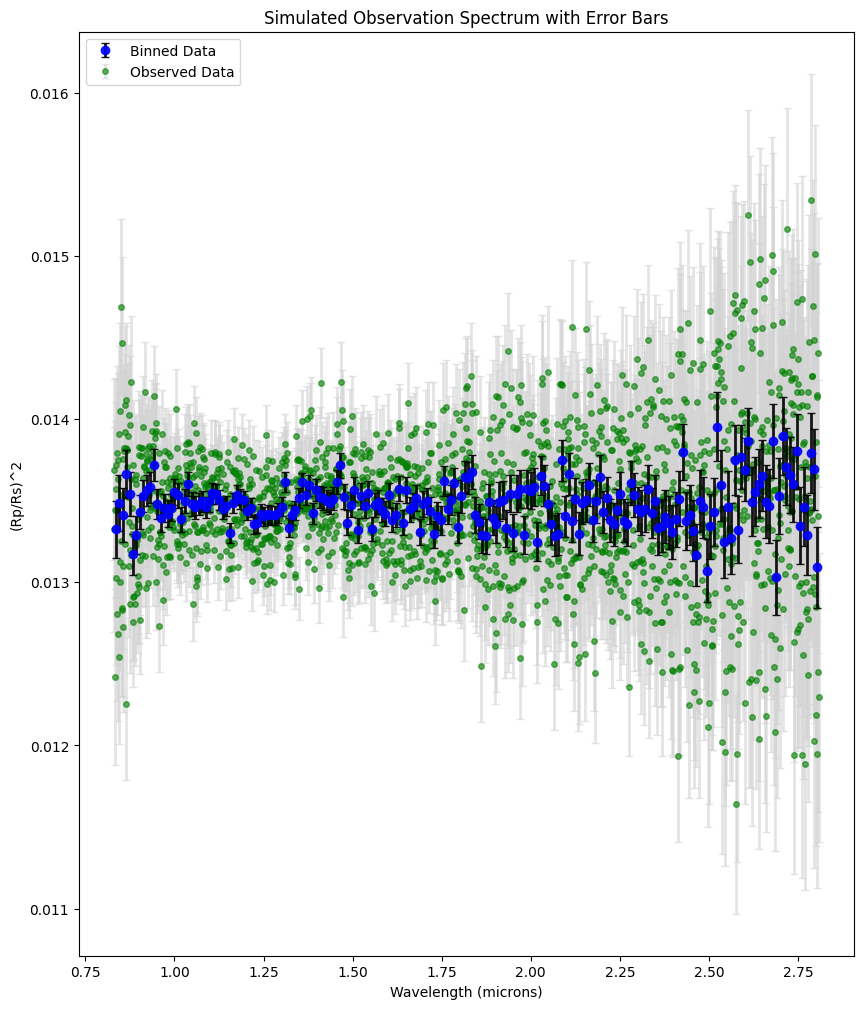

In [102]:
def One_File():
    """This is the main function that will execute when the script is run.
    Can change to be whatever you want to run."""
    data=  np.loadtxt('Data/sim_obs (2).txt') # load the data 
    mask = data[:, 3] <= 0.001 # take out the bit where the error bars go crazy 
    Proper_datset = data[mask] #data after applying the mask

    Wavelengths= Proper_datset[:,0] # in microns
    Spectrum= Proper_datset[:,2] # data with the noise (Rp/Rs)^2
    error_bars= Proper_datset[:,3] # error bars 
    binned_data= PeakFinder().Binning(Proper_datset)
    peak_unbinned = PeakFinder().find_peaks(data)
    peak_binned = PeakFinder().find_peaks(binned_data)
    print(peak_unbinned, peak_binned)


    plt.figure(figsize=(10,12))
    #plt.scatter(Wavelengths, Spectrum)
    plt.errorbar(binned_data[:,0], binned_data[:,2], yerr=binned_data[:,3], fmt='o', label='Binned Data', zorder= 2, alpha=0.9, color='blue', ecolor='k', elinewidth=2, capsize=3, markersize=6)
    plt.errorbar(Wavelengths, Spectrum, yerr=error_bars, fmt='o', label='Observed Data', zorder= 1, alpha=0.6, color='green', ecolor='lightgray', elinewidth=2, capsize=3, markersize=4)
    #plt.ylim(min(data[:,1]), max(data[:,1]))
    plt.xlabel('Wavelength (microns)')
    plt.ylabel('(Rp/Rs)^2')
    plt.title('Simulated Observation Spectrum with Error Bars')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    One_File()

[0.0778628  0.25979637 0.23142545 0.76026027 0.55768162 0.27294015
 0.13351213 0.48537852 0.31586047 0.91128723]


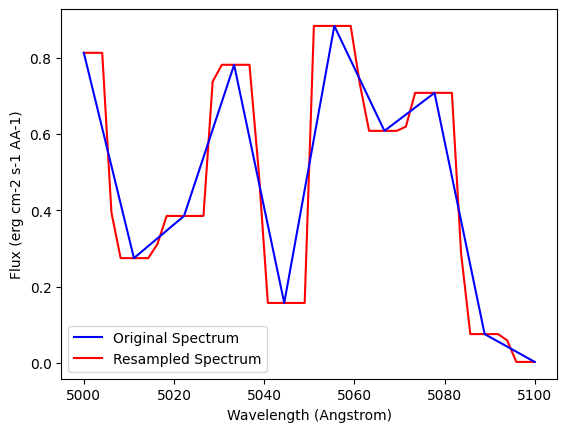

In [58]:
import numpy as np
import astropy.units as u
from specutils import Spectrum
from specutils.manipulation import FluxConservingResampler
import matplotlib.pyplot as plt
print(np.random.random(10))
wave = np.linspace(5000, 5100, 10) * u.AA
#flux = np.random.random(10) * u.Unit("erg cm-2 s-1 AA-1")
flux = np.array([0.81306158, 0.27469256, 0.38526647, 0.78165338, 0.15717256, 0.88356331,
 0.60842991, 0.70807226, 0.07552976, 0.00253725]) * u.Unit("erg cm-2 s-1 AA-1")
spec = Spectrum(spectral_axis=wave, flux=flux)
new_wave = np.linspace(5000, 5100, 50) * u.AA
resampler = FluxConservingResampler()
new_spec = resampler(spec, new_wave)

plt.plot(spec.spectral_axis, spec.flux, zorder= 2, label='Original Spectrum', color='blue')
plt.xlabel("Wavelength (Angstrom)") 
plt.plot(new_spec.spectral_axis, new_spec.flux, label='Resampled Spectrum', color='red', zorder= 1)
plt.ylabel("Flux (erg cm-2 s-1 AA-1)")
plt.legend()
plt.show()